In [206]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
# from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from nltk.probability import FreqDist
# Some packages for NER.
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm
import random
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /Users/Umang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
train = pd.read_csv("data/fake-news/train.csv")
test  = pd.read_csv("data/fake-news/test.csv")
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [105]:
print("Shape of training data {}".format(train.shape))
print("Shape of test data {}".format(test.shape))


Shape of training data (20800, 5)
Shape of test data (5200, 4)


# Data Pre-Processing and Cleaning

### Looking at the count of nulls in the data and filling them with blank spaces, this is done to make sure the later steps of Data pre-processing and model don't break

In [106]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [107]:
train = train.fillna(" ")
test  = test.fillna(" ")

### We create a synthetic feature called merged, by combining the title and author features together, this is done for 2 purposes:
1. Classification of the news depends on both author and the content, hence a single feature would be better for learning 
2. The algorithm would only have a single feature to learn on.
 

In [109]:
train["merged"] = train["title"]+" "+train["author"]
test["merged"]  = test["title"]+" "+test["author"]

### Data Pre-Processing.We perform the following pre-processing steps:
    1. All the punctuations/sequences are removed, they don't really help in the model learning
    2. To prevent confusion and to ease the feature extraction process, we convert everything to lower case
    3. We then make a continous stream of tokens rather than sentences
    4. Then we do stemming which is a common NLP pre-procesing step, it reduces the word to its root word for e.g chocolaty becomes chocolate   

In [110]:
# Creating copy of the train and test dataframes for data pre-processing
X=train.drop(columns=['label'],axis=1)
y=train.label
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [111]:
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)

In [112]:
cleanText=pd.Series(train_corpus)
frame={'Text':cleanText, 'Label':y}
cleanData=pd.DataFrame(frame)

In [ ]:
lis_text=[
    cleanData[cleanData['Label'] == 0]['Text'],
    cleanData[cleanData['Label'] == 1]['Text'],
]

# Exploratory Data Analysis

### We start by looking at histogram of the length of sentences for both reliable and fake news. The following insight comes up:
Length of reliable news articles is lesser than unreliable news articles in general

/Users/Umang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


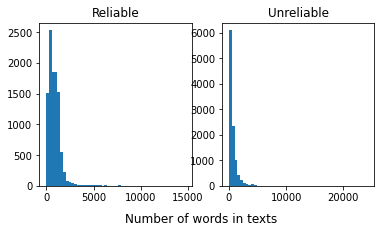

In [129]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,3))
text_len=train[train.label==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, bins = 50)
ax1.set_title('Reliable')
text_len=train[train.label==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, bins = 50)
ax2.set_title('Unreliable')
fig.suptitle('Number of words in texts', y=0)
fig.show()

### Secondly we look at the distribution of labels, i.e how many reliable vs unreliable news articles do we have in the data. Data has almost equal amount of both reliable and unreliable news, this tells us we won't have a <b>Class Imbalance problem<b> 

/Users/Umang/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


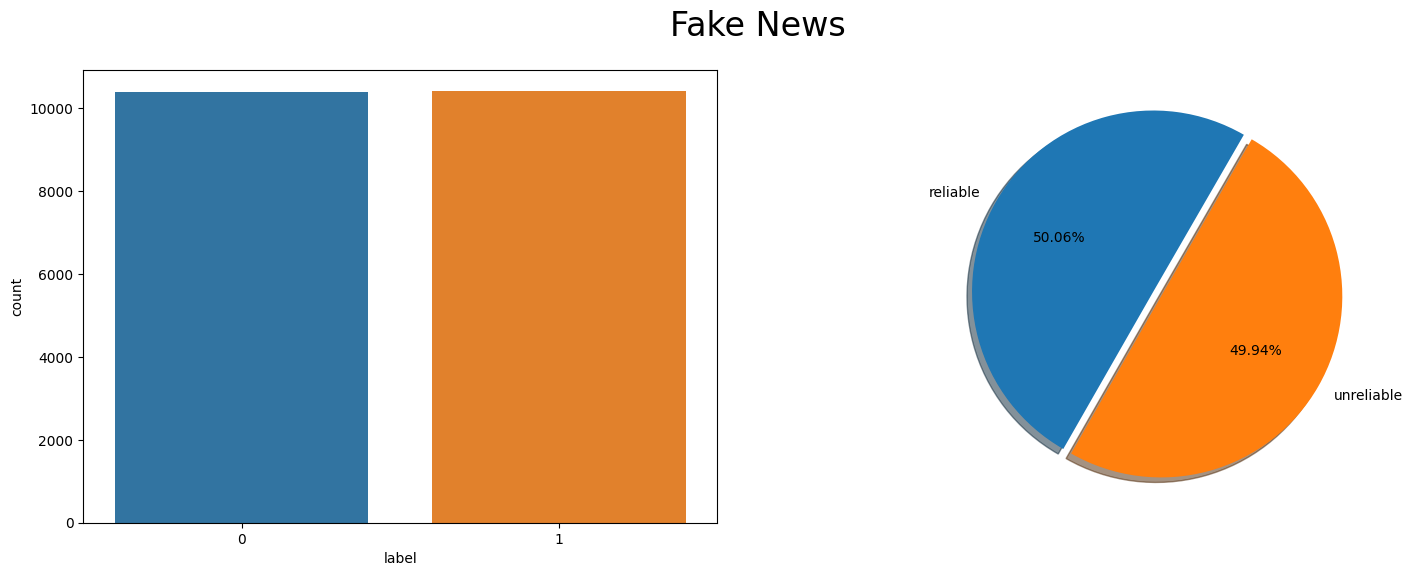

In [113]:
# Displaying target distribution.
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(y, ax=axes[0])
axes[1].pie(y.value_counts(),
            labels=['reliable', 'unreliable'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Fake News', fontsize=24)
plt.show()

### We also look at the most n-gramsin both reliable and unreliable news data. We create a general <i>ngrams</i> function which can show us common unigrams, bigrams, trigrams etc. The following insight comes:
1. New is the most common word in reliable news and trump is most common one in ubnreliable news articles
2. This analysis can be further done for bi-

In [138]:
def ngrams(n, title, lis_type):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis_type, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Reliable')
        axes[1].set_title('Unreliable')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

#### The following insight can be seen as we look at bigrams and trigrams plot using our general ngrams function:
1. New York is the most common bigram in the reliable news and hillari clinton is most common one in unreliable
2. New york time is the most common trigam in the reliable and norepli blogger com in the unreliable one

This tells us if these bigrams or trigrams are present in an article, there's a pretty strong chance that they'd be reliable or unreliable.

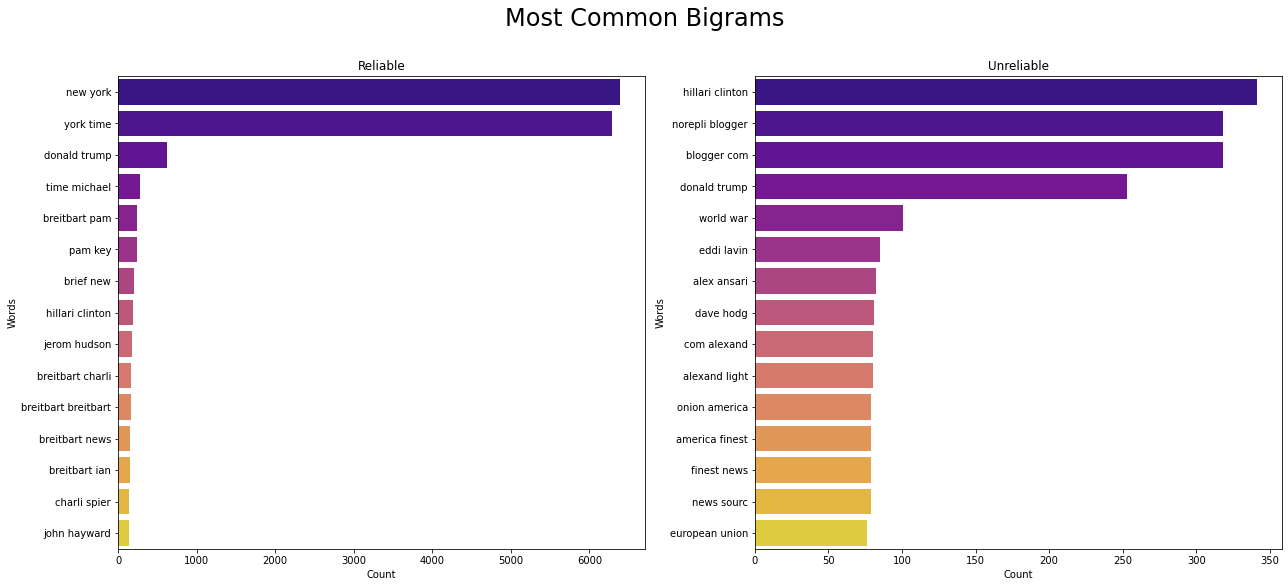

In [139]:
ngrams(2, 'Most Common Bigrams', lis_text)

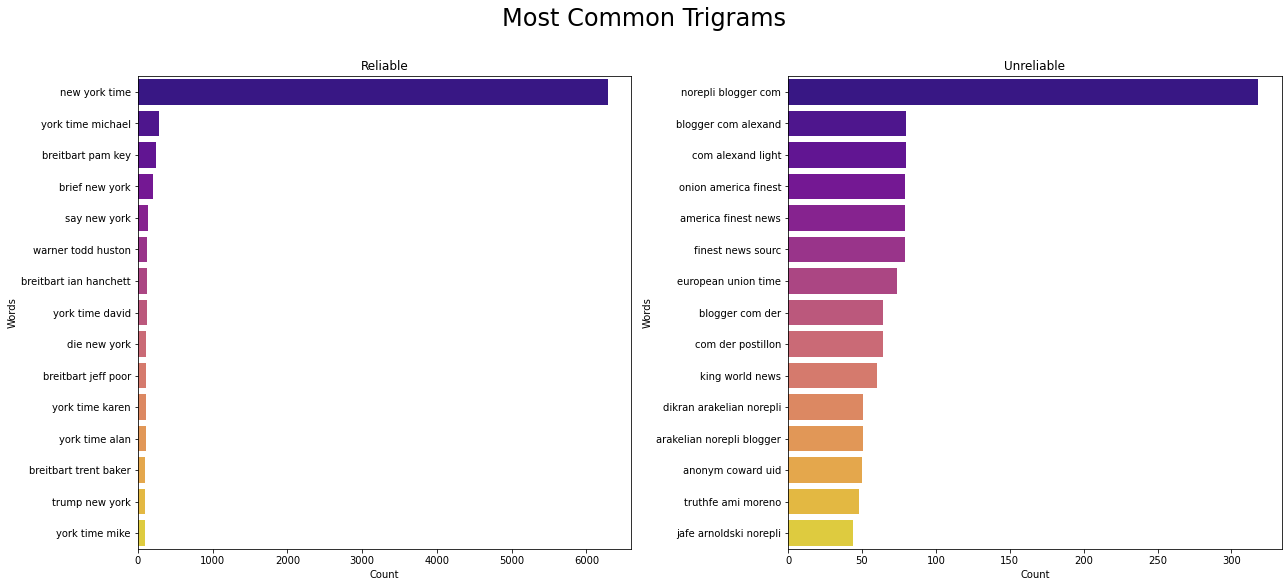

In [204]:
ngrams(3, 'Most Common Trigrams', lis_text)

### Moving ahead, we look at the word cloud of both reliable and unreliable news, word clouds give us a pretty good picture of the terms present in the data. The size of the words in the word cloud is proportional to how frequently they appear in the data

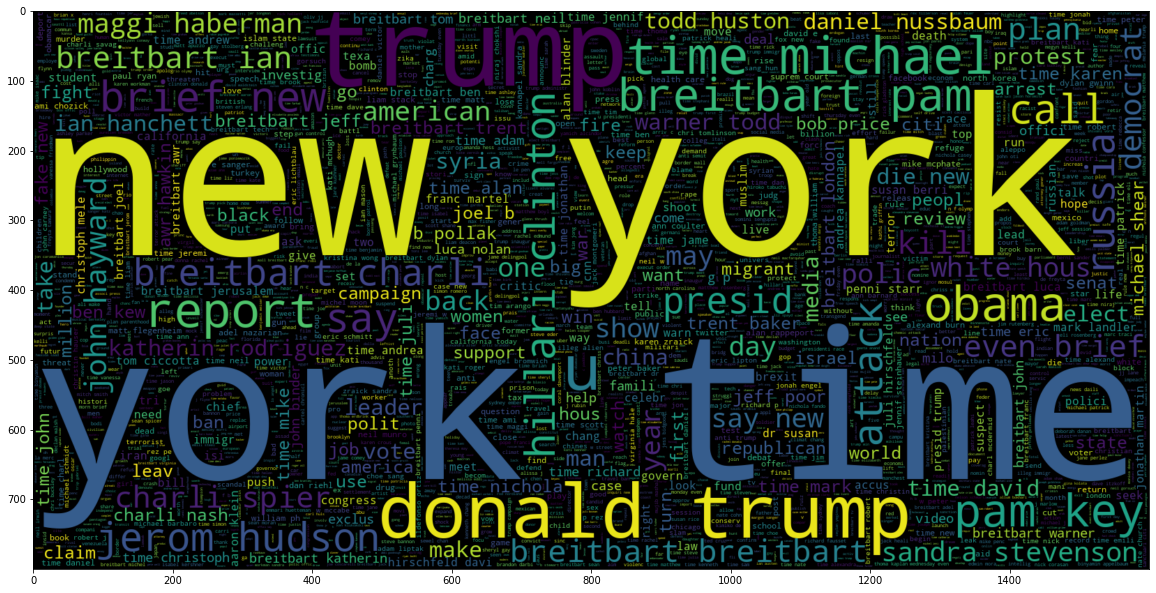

In [116]:
plt.figure(figsize = (20,20)) # Text that is not Fake(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(cleanData[cleanData.Label == 0].Text))
plt.imshow(wc , interpolation = 'bilinear')

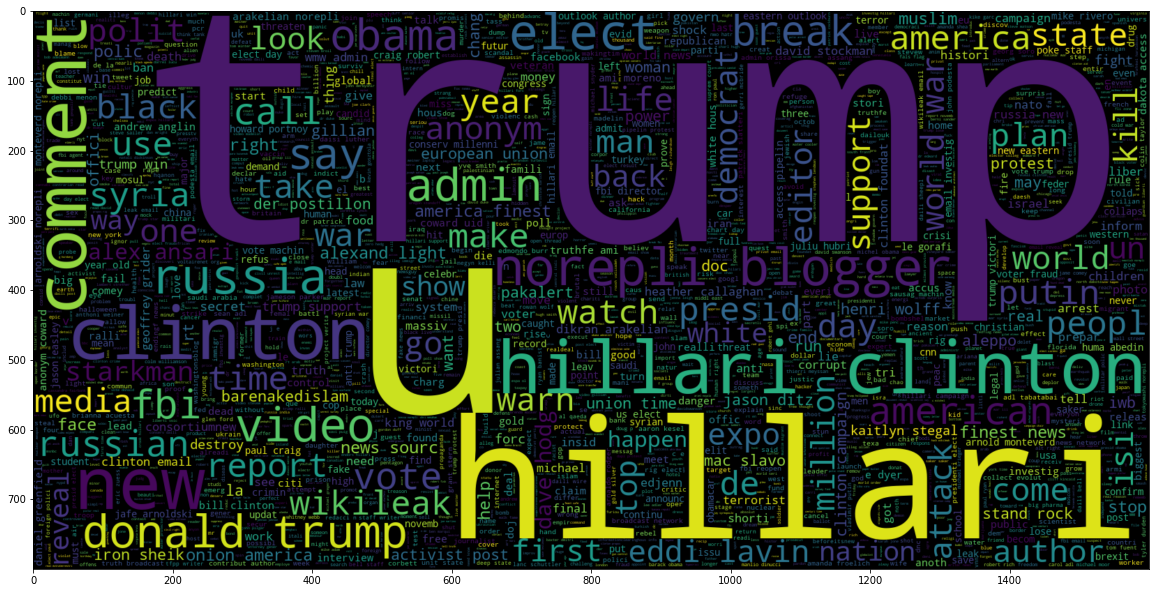

In [117]:
plt.figure(figsize = (20,20)) # Text that is not Fake(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(cleanData[cleanData.Label == 1].Text))
plt.imshow(wc , interpolation = 'bilinear')

### Before we start modeling work, we are creating a general function to plot confusion matrix for various models and easily visualise how they perform. 

In [141]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Feature Extraction, Modelling and Hyperparameter Tuning
### We try 4 different approaches for this dataset. 3 ML based approaches 1 Deep learning based. For every approach, we use a unique combination of a Feature extraction approach and a Model. We also perform Hyperparameter tuning for each approach except Deep learning one due to Compute limitations.

Majorly we try 2 Models in different combinations with Feature extraction approaches defined above:

#### 1. Multinomial NB:
In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features.
Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP). The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article. It calculates the probability of each tag for a given sample and then gives the tag with the highest probability as output.

#### 2. LSTM:
LSTM or long short term memory is a type of RNN that was developed to solve the problem of vanishing gradients, exploding gradients and is very good in understanding long term and short term dependencies among the text data. It has 3 gates that control these operations.

We try the following combinations:

| Feature Extraction | Model |
| :- | -: | 
| Count Vectorizer | Multinomial Naive Bayes 
| TF-IDF| Multinomial Naive Bayes 
| Hashing | Multinomial Naive Bayes 
| Word2Vec based Embedding | LSTM based Neural Net 

In [118]:
X_train, X_test, y_train, y_test = train_test_split(cleanData['Text'], cleanData['Label'], test_size=0.33,random_state=53)

### 1.Count Vectorizer 
The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

In [119]:
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

### Multinomial Naive Bayes 
We use Multinomial Naive Bayes model since this model is pretty suitable for classification with discrete features which in our case are word counts for text classificatio

accuracy:   0.946
[[3386   24]
 [ 346 3108]]
Confusion matrix, without normalization


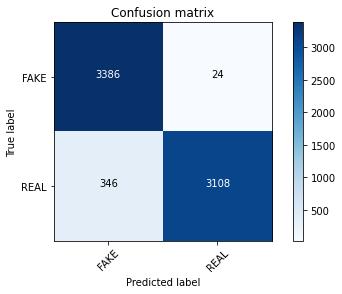

In [143]:
clf = MultinomialNB() 
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, )
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])


### Hyperparameter Tuning for Count Vectorizer+ MultinomialNB
We do a grid search from 0-1 for the alpha parameter of MultinomialNB and see the results, as can be seen 94% is the max accuracy we could reach with this combination

In [144]:
classifier=MultinomialNB(alpha=0.1)


previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(count_train,y_train)
    y_pred=sub_classifier.predict(count_test)
    score = accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.9181235431235432
Alpha: 0.1, Score : 0.9434731934731935
Alpha: 0.2, Score : 0.9456585081585082
Alpha: 0.30000000000000004, Score : 0.9472610722610723
Alpha: 0.4, Score : 0.9474067599067599
Alpha: 0.5, Score : 0.9472610722610723
Alpha: 0.6000000000000001, Score : 0.9472610722610723
Alpha: 0.7000000000000001, Score : 0.9466783216783217
Alpha: 0.8, Score : 0.9468240093240093
Alpha: 0.9, Score : 0.9459498834498834


/Users/Umang/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


### 2.TF-IDF Vectorizer
The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents. 

In [124]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

####  Modeling Training and Hyperparameter Tuning for TF-IDF+ MultinomialNB
Similar to earlier, we fit a MultinomialNB model now with TF-IDF features and also perform Hyperparameter tuning in a similar way, as can be seen below, 93% is the best accuracy we can reach with this combination.

accuracy:   0.934
[[3386   24]
 [ 432 3022]]
Confusion matrix, without normalization


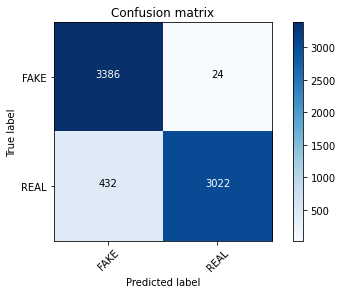

In [157]:
clf = MultinomialNB() 
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [158]:
classifier=MultinomialNB(alpha=0.1)
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(tfidf_train,y_train)
    y_pred=sub_classifier.predict(tfidf_test)
    score = accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.8898601398601399
Alpha: 0.1, Score : 0.9290501165501166
Alpha: 0.2, Score : 0.9315268065268065
Alpha: 0.30000000000000004, Score : 0.9335664335664335
Alpha: 0.4, Score : 0.9335664335664335
Alpha: 0.5, Score : 0.9331293706293706
Alpha: 0.6000000000000001, Score : 0.9331293706293706
Alpha: 0.7000000000000001, Score : 0.9337121212121212
Alpha: 0.8, Score : 0.9335664335664335
Alpha: 0.9, Score : 0.9332750582750583


/Users/Umang/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


### 3.Hashing
Counts and frequencies can be very useful, but one limitation of these methods is that the vocabulary can become very large.
This, in turn, will require large vectors for encoding documents and impose large requirements on memory and slow down algorithms.
A clever work around is to use a one way hash of words to convert them to integers. 

In [154]:

# Initialize the hashing vectorizer
hashing_vectorizer = HashingVectorizer(stop_words='english',n_features=5000,alternate_sign=False)

# Fit and transform the training data 
hashing_train = hashing_vectorizer.fit_transform(X_train)

# Transform the test set 
hashing_test = hashing_vectorizer.transform(X_test)



####  Modeling Training and Hyperparameter Tuning for Hashing + MultinomialNB
Similar to earlier, we fit a MultinomialNB model now with Hashing features and also perform Hyperparameter tuning in a similar way, as can be seen below, 93% is the best accuracy we can reach with this combination.

accuracy:   0.931
[[3313   97]
 [ 379 3075]]
Confusion matrix, without normalization


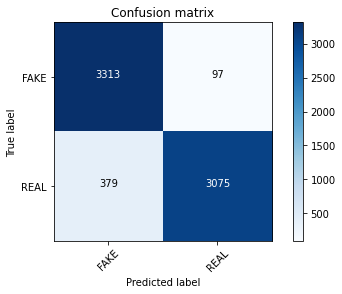

In [159]:
clf = MultinomialNB() 
clf.fit(hashing_train, y_train)
pred = clf.predict(hashing_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred)
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [160]:
classifier=MultinomialNB(alpha=0.1)
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(hashing_train,y_train)
    y_pred=sub_classifier.predict(hashing_test)
    score = accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.8901515151515151
Alpha: 0.1, Score : 0.9290501165501166
Alpha: 0.2, Score : 0.9296328671328671
Alpha: 0.30000000000000004, Score : 0.9310897435897436
Alpha: 0.4, Score : 0.9310897435897436
Alpha: 0.5, Score : 0.9312354312354313
Alpha: 0.6000000000000001, Score : 0.9306526806526807
Alpha: 0.7000000000000001, Score : 0.9309440559440559
Alpha: 0.8, Score : 0.930506993006993
Alpha: 0.9, Score : 0.930506993006993


/Users/Umang/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


### 4. Word2vec based Word Embedding
Now we try a Deep learning based Feature extraction approach as well as the Deep learning Model.
Word embedding is one of the document representation in vector space model. It captures contexts and semantics of word unlike Bag-of-Words model. 
Word2vec is one of the most popular implementation of word embedding, which is invented by Google in 2013. It describes word embedding with two-layer shallow neural networks in order to recognize context meanings.
There are 2 ways to create word embeddings:

1. Using word embedding in an unsupervised way: This means that, based on the sentences we have, the model tries to capture the context of a word in a document, that is, the relation to other words, semantic and syntactic similarities, etc...
2. Using word embedding as a first layer in the neural network/LSTM. This means that the weights are learned through backpropagation of the classification error. Therefore, weights are learned by backpropagating the classification error. The model does not necessarily try to capture the context of a word in a document, it adjusts the weights only in such a way as to reduce loss.

We will use here the first method. It is faster because the embedding only needs to be done once, and not on each iteration of the LSTM training. An advantage of the first method is the possibility of using pre-trained models, that is, models which have already associated the words with vectors.

We could have also used pre-trained embeddings instead of training our own using gensims' word2vec using the stored model here https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing 
but they need a good amount of memory(~12GB+ RAM) and space to load which we dont have.



#### For Word2Vec we need to convert the data into the formart accepted by Word2Vec Model. It needs a continous list of words in a lists of lists tokenized

In [208]:
X = []

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in cleanData["Text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens]
        tmp.extend(filtered_words)
    X.append(tmp)


#### We now create our word embedding using word2Vec using the data that we just created

In [209]:
import gensim 
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X,vector_size=EMBEDDING_DIM, window=5, min_count=1)

##### Looking at Similar words using w2v model



In [210]:
sims = w2v_model.wv.most_similar('clinton', topn=10)  # get other similar words
sims

[('email', 0.9792633056640625),
 ('fbi', 0.9730289578437805),
 ('investig', 0.9659456610679626),
 ('hillari', 0.962849497795105),
 ('reopen', 0.9588966965675354),
 ('batch', 0.9462899565696716),
 ('crook', 0.9429541230201721),
 ('wikileak', 0.9398213028907776),
 ('fixer', 0.9380461573600769),
 ('campaign', 0.9376758337020874)]

In [211]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [212]:
sent_length = 20
X = pad_sequences(X,padding='pre',maxlen=sent_length)


In [213]:
vocab_size = len(tokenizer.word_index) + 1

### Neural Net  with Word2vec
Once we got the word2Vec embeddings we Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer
Embedding layer accepts numecical-token of word and outputs corresponding vector to inner layer.
It sends vector of zeros to next layer for unknown words which would be tokenized to 0.



In [214]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [215]:
word_index = tokenizer.word_index

In [216]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

### Creating the Neural Network
We create a simple Neural network with Embedding as the input and 1 LSTM unit followed by a dense layer  for results. For word embeddings, we use the Keras Embedding layer and make it untrainable since we already created that with gensim's word2vec

In [217]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=sent_length, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [218]:
y=train['label'].values
y=np.array(y)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33) 

### We don't perform Hyperparameter tuning due to lack of compute power, also because this is a pretty simple model and doesn't require that much hyperparameter tuning. 

### As can be seen this combination of Word2Vec and LSTM gives us the best result so far 98% accuracy.

In [220]:
model.fit(X_train, y_train,validation_split=0.3, epochs=6)

Epoch 1/6
305/305 [==============================] - 9s 31ms/step - loss: 0.1770 - acc: 0.9252 - val_loss: 0.1139 - val_acc: 0.9577
Epoch 2/6
305/305 [==============================] - 13s 44ms/step - loss: 0.1170 - acc: 0.9545 - val_loss: 0.0939 - val_acc: 0.9670
Epoch 3/6
305/305 [==============================] - 10s 32ms/step - loss: 0.0989 - acc: 0.9607 - val_loss: 0.0841 - val_acc: 0.9672
Epoch 4/6
305/305 [==============================] - 13s 44ms/step - loss: 0.0854 - acc: 0.9677 - val_loss: 0.0832 - val_acc: 0.9715
Epoch 5/6
305/305 [==============================] - 10s 32ms/step - loss: 0.0768 - acc: 0.9716 - val_loss: 0.0699 - val_acc: 0.9715
Epoch 6/6
305/305 [==============================] - 8s 27ms/step - loss: 0.0695 - acc: 0.9745 - val_loss: 0.0656 - val_acc: 0.9778


In [221]:
y_pred = (model.predict(X_test) > 0.5).astype("int")

In [222]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3397
           1       0.96      0.99      0.97      3467

    accuracy                           0.97      6864
   macro avg       0.97      0.97      0.97      6864
weighted avg       0.97      0.97      0.97      6864



[[3241  156]
 [  25 3442]]
Confusion matrix, without normalization


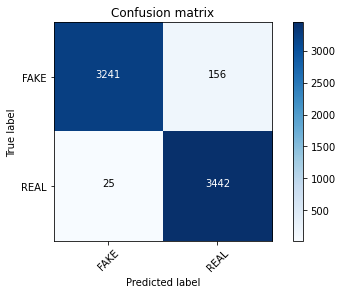

In [223]:

cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Conclusion

## In conclusion, we tried multiple feature extraction approaches, better the feature extraction usually better the results are. Also choice of model becomes important after finding a good representation of data.

## Word2Vec+LSTM gives us the best results. The reason for that is that Word Embeddings captures all the semantics behind words and also the relationship between the words very well and provied a good representation of words. Also LSTM being an RNN works very well with texts and captures long term relationships and short term relationships amongst words without having problems of exploding and vanishing gradients.